## Data Simulation

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import multivariate_normal
np.random.seed(1)
from sklearn.utils import shuffle


Function to generate data from a ground truth model with K classes and η-dependent covariance

In [17]:
import numpy as np

def generate_data(n_per_class, eta, K, means, shared_cov, class_covs):
    
    X_list, y_list = [], [] # Use _list suffix to clearly indicate they are lists of arrays

    for i in range(K):
        # Calculate the blended covariance matrix based on eta
        cov = (1 - eta) * shared_cov + eta * class_covs[i]
        
        # Add a small epsilon to the diagonal for numerical stability
        # This helps prevent LinAlgError due to singular or non-positive definite matrices
        #epsilon = 1e-6 
        #cov = cov + np.eye(cov.shape[0]) * epsilon
        
        # Generate multivariate normal samples for the current class
        X_list.append(np.random.multivariate_normal(means[i], cov, size=n_per_class))
        y_list.append(np.full(n_per_class, i))
    
    # Vertically stack all class feature arrays into a single data matrix
    X = np.vstack(X_list)
    # Horizontally stack all class label arrays into a single label vector
    y = np.hstack(y_list)
    
    # Permute the data to ensure samples from different classes are interleaved
    # This is important for robust splitting and training
    rng = np.random.default_rng(seed=42)
    perm = rng.permutation(len(y))

    X = X[perm]
    y = y[perm]
    
    return X, y

Base simulation setup
- Create smooth class covariance matrices with varying correlations
- Correlation smoothly varies between -1 and 1

In [18]:
def setup_simulation(K, eta, n_train, print_covariances=False):
    np.random.seed(1)

    # Arrange class means in a grid pattern
    means = [np.array([i * 2, j * 2])
             for i in range(int(np.ceil(K**0.5)))
             for j in range(int(np.ceil(K**0.5)))]
    means = means[:K]

    shared_cov = np.array([[1, 0], [0, 1]])  # Identity
    n_per_class = n_train // K

    # Generate distinct elliptical and rotated covariances
    class_covs = []
    for k in range(K):
        angle = (np.pi / K) * k  # unique angle per class
        rotation = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle),  np.cos(angle)]
        ])
        scales = np.diag([1.0 + 0.5 * k, 0.3 + 0.2 * (K - k)])  # different eigenvalues
        cov_k = rotation @ scales @ rotation.T
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)  # ensure symmetry & stability
        class_covs.append(cov_k)

    # Generate data
    X_train, y_train = generate_data(n_per_class=n_per_class, eta=eta, K=K,
                                     means=means, shared_cov=shared_cov, class_covs=class_covs)

    X_train, y_train = shuffle(X_train, y_train, random_state=1)
    # Optionally print empirical covariances
    if print_covariances:
        print(f"\nEmpirical covariance matrices (η = {eta}):")
        for i in range(K):
            X_class = X_train[y_train == i]
            if len(X_class) > 1:
                cov = np.cov(X_class, rowvar=False)
                print(f"Class {i}:\n{cov}\n")
            else:
                print(f"Class {i}: Not enough samples to compute empirical covariance.\n")

    return X_train, y_train, means, shared_cov, class_covs


## Models

Function to compute Bayes classifier predictions

In [19]:
def compute_bayes_predictions(X, means, shared_cov, class_covs, eta):
    K = len(means)
    n = X.shape[0]
    probs = np.zeros((n, K))
    priors = np.full(K, 1.0 / K)  # uniform priors


    for k in range(K):
        sigma_k = (1 - eta) * shared_cov + eta * class_covs[k]
        sigma_k = (sigma_k + sigma_k.T) / 2  # enforce symmetry
        sigma_k += np.eye(sigma_k.shape[0]) * 1e-6  # add epsilon for numerical stability

        rv = multivariate_normal(mean=means[k], cov=sigma_k)
        probs[:, k] = rv.pdf(X) * priors[k]

    probs /= probs.sum(axis=1, keepdims=True)
    predictions = np.argmax(probs, axis=1)
    return predictions, probs


In [20]:
import numpy as np
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def compute_lda_predictions(X_train, y_train, X_test):
    model = LinearDiscriminantAnalysis().fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    return preds, probs, model


In [21]:

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def compute_qda_predictions(X_train, y_train, X_test):
    model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    return preds, probs, model



In [22]:
# Parameters

K = 3
eta = 0
n_train = 200
n_test = 50

# Generate train and test data
X_train, y_train, means, shared_cov, class_covs = setup_simulation(K, eta, n_train)
X_test, y_test, _, _, _ = setup_simulation(K, eta, n_test)

# Bayes predictions
bayes_preds, bayes_probs = compute_bayes_predictions(X_test, means, shared_cov, class_covs, eta)

# LDA predictions
lda_preds, lda_probs, lda_model = compute_lda_predictions(X_train, y_train, X_test)

# QDA predictions
qda_preds, qda_probs, qda_model = compute_qda_predictions(X_train, y_train, X_test)

# Evaluation
def evaluate(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    ll = log_loss(y_true, y_prob)
    print(f"{name} — Accuracy: {acc:.3f}, Log Loss: {ll:.3f}")

evaluate("Bayes", y_test, bayes_preds, bayes_probs)
evaluate("LDA", y_test, lda_preds, lda_probs)
evaluate("QDA", y_test, qda_preds, qda_probs)


Bayes — Accuracy: 0.875, Log Loss: 0.341
LDA — Accuracy: 0.917, Log Loss: 0.322
QDA — Accuracy: 0.875, Log Loss: 0.326


# Plot

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lda_decision_boundary(X, y, model, title="LDA Decision Boundary"):
    # Create a fine mesh grid over the input space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict class labels over the grid
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training points
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
def plot_qda_decision_boundary(X, y, model, title="QDA Decision Boundary"):
    # Create a fine mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict class labels over the grid
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plot contours and training points
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
def plot_bayes_decision_boundary(X, y, means, shared_cov, class_covs, eta, title="Bayes Decision Boundary"):
    from scipy.stats import multivariate_normal

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Compute class posteriors manually using true parameters
    K = len(means)
    priors = np.full(K, 1.0 / K)
    probs = np.zeros((grid.shape[0], K))

    for k in range(K):
        cov_k = (1 - eta) * shared_cov + eta * class_covs[k]
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)  # stabilize
        rv = multivariate_normal(mean=means[k], cov=cov_k)
        probs[:, k] = rv.pdf(grid) * priors[k]

    preds = np.argmax(probs, axis=1)
    Z = preds.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


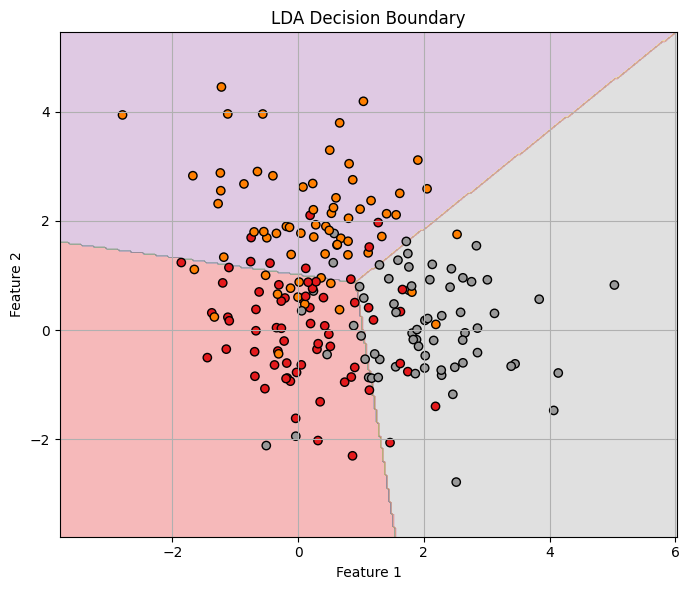

In [26]:
plot_lda_decision_boundary(X_train, y_train, lda_model)

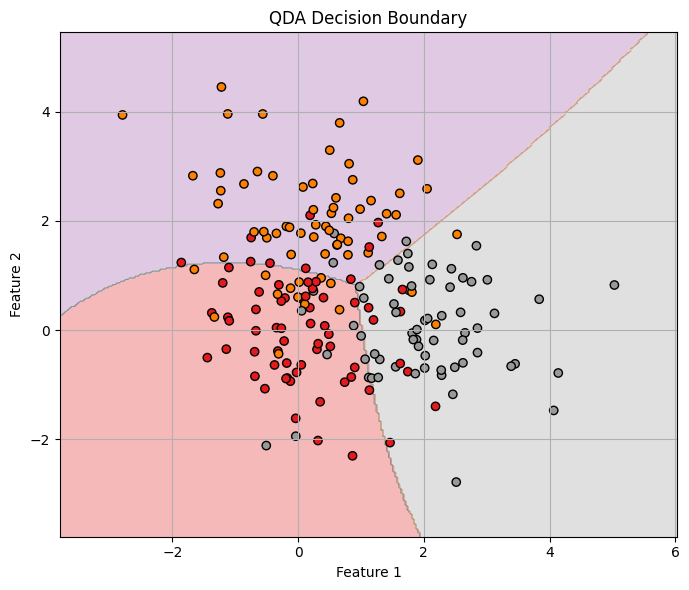

In [27]:
plot_qda_decision_boundary(X_train, y_train, qda_model)

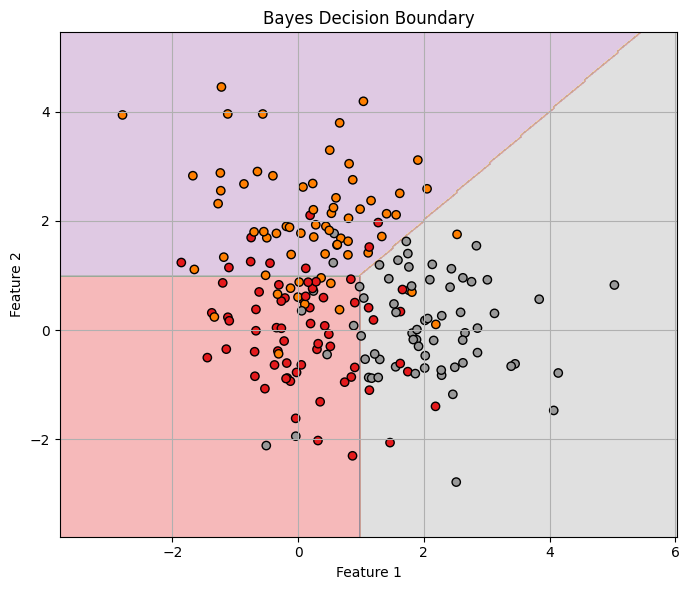

In [28]:
plot_bayes_decision_boundary(X_train, y_train, means, shared_cov, class_covs, eta)

## combined

In [29]:
def plot_combined_boundaries(X, y, lda_model, qda_model, means, shared_cov, class_covs, eta):
    from scipy.stats import multivariate_normal
    from matplotlib.colors import ListedColormap

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict class labels
    lda_Z = lda_model.predict(grid).reshape(xx.shape)
    qda_Z = qda_model.predict(grid).reshape(xx.shape)

    # Bayes decision
    K = len(means)
    priors = np.full(K, 1.0 / K)
    probs = np.zeros((grid.shape[0], K))

    for k in range(K):
        cov_k = (1 - eta) * shared_cov + eta * class_covs[k]
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)
        rv = multivariate_normal(mean=means[k], cov=cov_k)
        probs[:, k] = rv.pdf(grid) * priors[k]
    bayes_Z = np.argmax(probs, axis=1).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))

    # Background colours: soft red, blue, green
    background_cmap = ListedColormap(['#ffe6e6', '#e6f0ff', '#e6ffe6'])
    plt.contourf(xx, yy, bayes_Z, alpha=0.8, cmap=background_cmap)

    # Overlay contour lines (decision boundaries)
    plt.contour(xx, yy, bayes_Z, colors='grey', linestyles='-', linewidths=2)
    plt.contour(xx, yy, lda_Z, colors='orange', linestyles='--', linewidths=1.5)
    plt.contour(xx, yy, qda_Z, colors='purple', linestyles='-.', linewidths=1.5)


    # Scatter data points: red, blue, green
    colors_points = np.array(['red', 'blue', 'green'])
    plt.scatter(X[:, 0], X[:, 1], c=colors_points[y], edgecolor='k', s=40)

    # Labels and legend
    plt.title("LDA vs QDA vs Bayes ($\\Sigma_1$ = $\\Sigma_2$ = $\\Sigma_3$)")
    #plt.title("LDA vs QDA vs Bayes ($\\Sigma_1$ ≠ $\\Sigma_2$ ≠ $\\Sigma_3$)")
    plt.xlabel("X 1")
    plt.ylabel("X 2")
    plt.grid(True)
    plt.tight_layout()

    custom_lines = [
        plt.Line2D([0], [0], color='grey', lw=2, label='Bayes'),
        plt.Line2D([0], [0], color='orange', linestyle='--', lw=1.5, label='LDA'), 
        plt.Line2D([0], [0], color='purple', linestyle='-.', lw=1.5, label='QDA')
        ]   
    plt.legend(handles=custom_lines)
    plt.show()


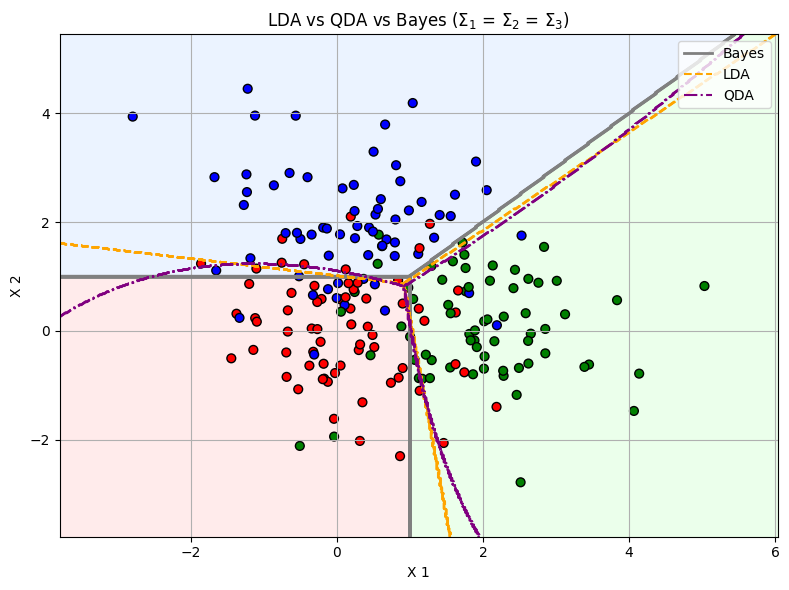

In [30]:
plot_combined_boundaries(X_train, y_train, lda_model, qda_model, means, shared_cov, class_covs, eta)